In [3]:
import pandas as pd
import numpy as np
from copy import deepcopy
from statistics import mean

In [4]:
def _get_kfolds_when_train_test_equal( x,y, folds, is_random):
        """
        Get indices for train and test kfold data assuming that number of patients in the training
        cohort is equivalent to number of patients in testing. For cases in normal kfold where we
        are just iterating over the entire dataset this will be true.

        Gathers a list of patients and splits them by pathophysiology. Then just takes a continuous
        kfold split of them.
        """

        
        idxs = []
        pathos = {0:'Not readmitted',1:'Readmitted'}
        mapping = {patho: [] for n, patho in pathos.items()}
        samples = deepcopy(x)
        
        if is_random:
            samples.sample(frac=1)
        
        # print(samples)                                                                                            
        for idx,*patient in samples.itertuples():
            
            type_ = pathos[y.loc[idx]]
            mapping[type_].append(idx)
            
        for i in range(folds):
            test_pts = []
            train_pts = []
            for k, v in mapping.items():
                # print("######",k,v)
                lower_bound = int(round(i * len(v) / float(folds)))
                upper_bound = int(round((i + 1) * len(v) / float(folds)))
                if upper_bound < 1:
                    raise Exception("You do not have enough patients for {} cohort".format(k))
                # print(lower_bound,upper_bound)
                patients = v[lower_bound:upper_bound]
                # print(patients,test_pts)
                test_pts.extend(patients)
            # train_pts = x.index - test_pts
            train_pts = set(x.index).difference(test_pts)
            train_pts = list(train_pts)
            test_pts = set(test_pts)
            test_pts = list(test_pts) 

            print("-----> K-Fold train and test size <-----")
            print(len(train_pts),len(test_pts))
            print()
            # train_pt_data = x[x.deidentified_study_id.isin(train_pts)]
            # test_pt_data = x[x.deidentified_study_id.isin(test_pts)]
            print(type(train_pts),type(test_pts))
            idxs.append((train_pts, test_pts))
        
        return idxs

In [5]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix,classification_report,roc_curve,precision_recall_curve,auc
from prettytable import PrettyTable


def get_metrics(test_y,predictions,table,fold):

    report = classification_report(test_y, predictions,output_dict=True)
    fpr, tpr, thresholds = roc_curve(test_y, predictions, pos_label=1)
    precision, recall, thresholds = precision_recall_curve(test_y, predictions,pos_label=1)

    auc_score = auc(fpr, tpr)
    prauc_score = auc(recall, precision)
    print("AUC score is",auc_score,"PR-AUC score is",prauc_score)


    cm1 = confusion_matrix(test_y,predictions)
    #     print('Confusion Matrix : \n', cm1)

    total1=sum(sum(cm1))
    #####from confusion matrix calculate accuracy
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    print ('Accuracy : ', accuracy1)

    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    print('Sensitivity : ', sensitivity1 )

    specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print('Specificity : ', specificity1)

    

    #table.field_names = ["Fold","Class", "precision", "recall", "f-1 score","sensitivity","specificity","Accuracy of expt","AUC","PRAUC"]
    clss_lbl='0'
    table.add_row([fold, 'NO Readmissn', report[clss_lbl]['precision'],report[clss_lbl]['recall'],report[clss_lbl]['f1-score'],sensitivity1,specificity1,report['accuracy'], auc_score,prauc_score])

    clss_lbl='1'
    table.add_row([fold, 'Readmissn', report[clss_lbl]['precision'],report[clss_lbl]['recall'],report[clss_lbl]['f1-score'],sensitivity1,specificity1,report['accuracy'], auc_score,prauc_score])
    return table,accuracy1,auc_score,prauc_score

# Missing vlaues treatment

In [23]:
# train_x=train_x.replace(to_replace = np.nan, value = -1000)
# test_x=test_x.replace(to_replace = np.nan, value = -1000)

# train_x = train_x.replace(to_replace = 'NaN', value = -1000)
# test_x = test_x.replace(to_replace = 'NaN', value = -1000)

train_x=train_x.replace(to_replace ='unknown', value = np.nan)
test_x=test_x.replace(to_replace = 'unknown', value = np.nan)
maindata=maindata.replace(to_replace = 'unknown', value = np.nan)
maindata = maindata.replace(to_replace = 'NaN', value = -1000)

train_x=train_x.replace(to_replace ='unkown', value = np.nan)
test_x=test_x.replace(to_replace = 'unkown', value = np.nan)
maindata=maindata.replace(to_replace = 'unkown', value = np.nan)


# Using treated missing values for modeling

In [37]:
# np.random.seed(10)
# len(maindata[maindata['Readmitted (Y/N)']==0])-len(maindata[maindata['Readmitted (Y/N)']==1])
# #197
# remove_n = 197
# drop_indices = np.random.choice(maindata[maindata['Readmitted (Y/N)']==0].index, remove_n, replace=False)
# maindata = maindata.drop(drop_indices)
# maindata=maindata.reset_index(drop=True)


train_set = maindata.sample(frac=0.7)

#HOLD OUT TEST SET
# for testing on unseen data
test_set = maindata.loc[~maindata.index.isin(train_set.index)]

train_set=train_set.reset_index(drop=True)
test_set =test_set.reset_index(drop=True)
# train_x =  whole_cohot_ehr.loc[:, :]
train_x = train_set.loc[:, train_set.columns != 'Readmitted (Y/N)']
# train_x = train_x[train_x.deidentified_study_id<150].reset_index(drop=True)
train_y = train_set['Readmitted (Y/N)']#
# train_y = train_y[train_y.deidentified_study_id<150].reset_index(drop=True)

test_x = test_set.loc[:, test_set.columns != 'Readmitted (Y/N)']
# train_x = train_x[train_x.deidentified_study_id<150].reset_index(drop=True)
test_y = test_set['Readmitted (Y/N)']#


In [38]:
print(len(train_set),len(test_set))

104 44


In [6]:
from scipy.stats import ks_2samp
def statistical_filter(df,X,y, corr_th):
    #FOR PERFORMING STATISTICAL FEATURE SELECTION
    
    df_ks= pd.DataFrame(columns =('Features', 'KS score', 'p value'))
    def ks(feat1,feat2):
        d,p_val = ks_2samp(feat1,feat2)
        return d,p_val
    
    cohort = df.groupby(['Readmitted (Y/N)'])
    cols = X.columns
    for feat in cols:
        d,p_val = ks(cohort.get_group(0)[feat],cohort.get_group(1)[feat])
        data_append = {'Features': [feat], 'KS score': [d], 'p value': [p_val]}
        df_ks = pd.concat([df_ks,pd.DataFrame(data=data_append)], ignore_index= True)
    df_ks_sorted = df_ks.sort_values('KS score', ascending=False)
    df_ks_sorted.reset_index(drop = True, inplace= True)
    cols_ML = df_ks_sorted[df_ks_sorted['p value']<=0.1]['Features'].values
    X_KS_filtered= X[cols_ML]


    correlated_features = pd.DataFrame(columns = ('Feature A', 'Feature B', 'Correlation values (-1 to +1)'))
    data_col =set()
    # data_file = 'Expert_abp_vent_large_data.csv'
    # X, y, df = get_dataset(data_file)
    correlation_matrix = X_KS_filtered.corr()
    for i in range(len(correlation_matrix.columns)):

        for j in range(i):
            #print(str(i) + '-'+ str(j))
            if abs(correlation_matrix.iloc[i, j]) > corr_th:
                colnameA = correlation_matrix.columns[i]
                colnameB = correlation_matrix.columns[j]
                indexA = np.where(cols_ML == colnameA)
                indexB = np.where(cols_ML == colnameB)
                if indexA < indexB:
                    
                    data_col.add(colnameB) ## to remove the feature with 
                else: 
                
                    data_col.add(colnameA)
                #data_col.add(colnameB)
                data = {'Feature A':[colnameA], 'Feature B': [colnameB], 'Correlation values (-1 to +1)':[correlation_matrix.iloc[i, j]] }
                correlated_features = pd.concat([correlated_features,pd.DataFrame(data=data)], ignore_index = True)

    colm_drop =list(data_col)
    df_corrFiltered = X_KS_filtered.drop(colm_drop, axis =1)
#     print('Number of reduced features: {}'.format(df_corrFiltered.shape[1]))
#    print(df_corrFiltered.columns)
    return df_corrFiltered.columns.tolist(),correlated_features,df_ks_sorted,X_KS_filtered

In [7]:
from statistics import mean
print("average acc is",mean(avg_acc))
print("average auc is",mean(avg_auc))
print("average pr_auc is",mean(avg_prauc))

NameError: name 'avg_acc' is not defined

In [32]:
def do_cross_validation(train_x,train_y,col_names):
    from sklearn.ensemble import RandomForestClassifier

    from sklearn.metrics import confusion_matrix,classification_report,roc_curve,precision_recall_curve,auc
    from prettytable import PrettyTable
    import pickle

    from sklearn.preprocessing import StandardScaler
    from copy import deepcopy


    #Cross validation sets for train and test
    y = deepcopy(train_y)
    x = deepcopy(train_x)
    # x=x.loc[:, ~x.columns.isin(['ZIP_4','Zipcode_last4','ZIPCODE','Mixed (Asian, White, AA)','Mixed (Asian, White)','Asian','AA','Hispanic','White','Middle Eastern','Fiscal Year'])]
    # print(train_x)
    indices = _get_kfolds_when_train_test_equal(x,y,5,True)

    colnames = col_names


    table = PrettyTable()
    table.field_names = ["Fold","Class", "precision", "recall", "f-1 score","sensitivity","specificity","Accuracy of expt","AUC","PRAUC"]

    avg_auc = []
    avg_prauc = []
    currentprauc =0
    avg_acc = []
    for fold,(train_idx, test_idx) in enumerate(indices):
        scaler = StandardScaler()
        
        x_train_cv = x.loc[train_idx]
        x_test_cv = x.loc[test_idx]
        y_train_cv = y.loc[x_train_cv.index]
        y_test_cv = y.loc[x_test_cv.index]
        scaler.fit(x_train_cv)
        model = RandomForestClassifier()


        if len(x_train_cv) != 0:
            x_train_cv = pd.DataFrame(scaler.transform(x_train_cv), index=x_train_cv.index, columns=colnames)
        if len(x_test_cv) != 0:
            x_test_cv = pd.DataFrame(scaler.transform(x_test_cv), index=x_test_cv.index, columns=colnames)
        model.fit(x_train_cv, y_train_cv)
        # print(model.feature_importances_)

        feat_importances = pd.Series(model.feature_importances_, index=x_test_cv.columns)
        print("##########################")
        print(feat_importances.nlargest(5))
    #     print("Features sorted according to their importances as per random forests",vals,sep="\n")
        predictions = model.predict(x_test_cv)
        table,acc_temp,auc_temp,prauc_temp= get_metrics(y_test_cv,predictions,table,fold+1)
        avg_acc.append(acc_temp)
        avg_auc.append(auc_temp)
        avg_prauc.append(prauc_temp)
        
        if prauc_temp>currentprauc :
            with open('rforest.pickle', 'wb') as f:
                pickle.dump(model, f, -1)
            currentprauc=prauc_temp
    return table, mean(avg_acc),mean(avg_auc),mean(avg_prauc)

# Performance on holdout


In [9]:
def holdout_testing(train_x,test_x,train_y,test_y,cols,saved_model_path=None):
    # Now we can train model.
    from sklearn.ensemble import RandomForestClassifier

    # initialize model
    model = RandomForestClassifier()
    # don't use patient and breath_id columns
    # fit the model to training 
    # train_x = train_x.loc[:, ~train_x.columns.isin(['ZIP_4','Zipcode_last4','ZIPCODE','Mixed (Asian, White, AA)','Mixed (Asian, White)','Asian','AA','Hispanic','White','Middle Eastern','Fiscal Year'])]
    # test_x = test_x.loc[:, ~test_x.columns.isin(['ZIP_4','Zipcode_last4','ZIPCODE','Mixed (Asian, White, AA)','Mixed (Asian, White)','Asian','AA','Hispanic','White','Middle Eastern','Fiscal Year'])]

    train_x = train_x.loc[:,cols]
    test_x = test_x.loc[:,cols]
    if saved_model_path is not None:
        model = pickle.load(open(saved_model_path,'rb'))
    else:
        model.fit(train_x, train_y)
    # Now that the model is fitted evaluate how well it is performing
    predictions = model.predict(test_x)
    from sklearn.metrics import classification_report

    print(classification_report(test_y, predictions))
    feat_importances = pd.Series(model.feature_importances_, index=test_x.columns)
    print(feat_importances.nlargest(5))


    from sklearn.metrics import confusion_matrix,classification_report,roc_curve,precision_recall_curve,auc
    from prettytable import PrettyTable



    from sklearn.preprocessing import StandardScaler
    colnames = train_x.columns


    table2 = PrettyTable()
    table2.field_names = ["Fold","Class", "precision", "recall", "f-1 score","sensitivity","specificity","Accuracy of expt","AUC","PRAUC"]


    table2 = get_metrics(test_y,predictions,table2,1)
    return table2



In [10]:
holdout_testing(train_x,test_x,train_y,test_y, train_x.columns[~train_x.columns.isin(['ZIP_4','Zipcode_last4','ZIPCODE','Fiscal Year'])])

NameError: name 'train_x' is not defined

In [48]:
# Now we can train model.
from sklearn.ensemble import RandomForestClassifier

# initialize model
model = RandomForestClassifier()
# don't use patient and breath_id columns
# fit the model to training 
train_x = train_x.loc[:, ~train_x.columns.isin(['ZIP_4','Zipcode_last4','ZIPCODE','Mixed (Asian, White, AA)','Mixed (Asian, White)','Asian','AA','Hispanic','White','Middle Eastern','Fiscal Year'])]
test_x = test_x.loc[:, ~test_x.columns.isin(['ZIP_4','Zipcode_last4','ZIPCODE','Mixed (Asian, White, AA)','Mixed (Asian, White)','Asian','AA','Hispanic','White','Middle Eastern','Fiscal Year'])]

model.fit(train_x, train_y)
# Now that the model is fitted evaluate how well it is performing




RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [49]:
predictions = model.predict(test_x)
from sklearn.metrics import classification_report

print(classification_report(test_y, predictions))


              precision    recall  f1-score   support

           0       0.67      0.63      0.65        19
           1       0.73      0.76      0.75        25

    accuracy                           0.70        44
   macro avg       0.70      0.70      0.70        44
weighted avg       0.70      0.70      0.70        44



In [50]:
print(model.feature_importances_)

shape_index = {i:j for i,j in zip(train_x.columns,model.feature_importances_)}
vals = sorted(shape_index, key=lambda k: shape_index[k])
print("Features sorted according to their importances as per random forests",vals,sep="\n")

[0.00912193 0.00312896 0.1801915  0.12536824 0.14364517 0.06360549
 0.01159821 0.01693151 0.00980961 0.         0.03051644 0.02739633
 0.00827217 0.00689973 0.00837849 0.00890396 0.         0.00763553
 0.00233488 0.01244881 0.01232287 0.0145032  0.02433178 0.02378613
 0.00314208 0.00425178 0.02102825 0.02067485 0.01619747 0.01557828
 0.01185272 0.01847304 0.01163093 0.00367778 0.02770911 0.01632911
 0.00644682 0.00262641 0.00493609 0.03216105 0.03215328]
Features sorted according to their importances as per random forests
['Other meds at dc', 'N_Diabetes', 'T1DM', 'superimposed with SF w/ SF', 'Meth/Cocaine use(Y/N)', 'Multiple', 'none', 'Singleton', 'superimposed without SF', 'superimposed with SF', 'Other', 'T1', 'Declined', 'A1GDM', 'A2GDM', 'Diabetes (Y/N)', 'Nifedipine dose at dc', 'If Y, how many?', 'gestational hypertension', 'No Episode', 'Preterm', 'T2DM', 'Term', 'Y_HDP Diag', 'N_HDP Diag', 'preeclampsia without SF', 'Betablocker dose at dc', 'chronic hypertension', 'Y_Multip

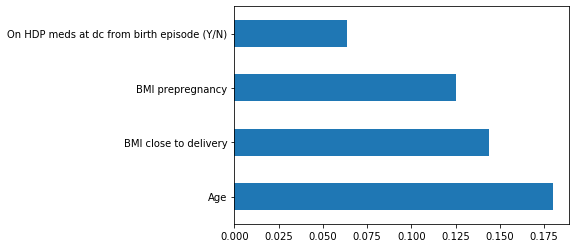

In [51]:
feat_importances = pd.Series(model.feature_importances_, index=test_x.columns)
feat_importances.nlargest(4).plot(kind='barh')

In [52]:


from sklearn.metrics import confusion_matrix,classification_report,roc_curve,precision_recall_curve,auc
from prettytable import PrettyTable



from sklearn.preprocessing import StandardScaler
colnames = train_x.columns


table2 = PrettyTable()
table2.field_names = ["Fold","Class", "precision", "recall", "f-1 score","sensitivity","specificity","Accuracy of expt","AUC","PRAUC"]


In [53]:
table2 = get_metrics(test_y,predictions,table2,1)

AUC score is 0.6957894736842105 PR-AUC score is 0.8135664335664335
Accuracy :  0.7045454545454546
Sensitivity :  0.631578947368421
Specificity :  0.76


NameError: name 'avg_auc' is not defined

In [ ]:
table2

(+------+--------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+
 | Fold |    Class     |     precision      |       recall       |     f-1 score      |    sensitivity     | specificity |  Accuracy of expt  |        AUC         |       PRAUC        |
 +------+--------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+
 |  1   | NO Readmissn |        0.9         | 0.9473684210526315 | 0.9230769230769231 | 0.9473684210526315 |     0.92    | 0.9318181818181818 | 0.9336842105263158 | 0.9618939393939395 |
 |  1   |  Readmissn   | 0.9583333333333334 |        0.92        | 0.9387755102040817 | 0.9473684210526315 |     0.92    | 0.9318181818181818 | 0.9336842105263158 | 0.9618939393939395 |
 +------+--------------+--------------------+--------------------+----

In [57]:
import pickle

In [58]:
saved_pickle_model = pickle.load(open('rforest.pickle','rb'))

/usr/lib/python3/dist-packages/sklearn/base.py:313: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:313: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [59]:
test_x = test_x.loc[:, ~test_x.columns.isin(['ZIP_4','Zipcode_last4','ZIPCODE','Mixed (Asian, White, AA)','Mixed (Asian, White)','Asian','AA','Hispanic','White','Middle Eastern','Fiscal Year'])]


preds =saved_pickle_model.predict(test_x)



from sklearn.metrics import confusion_matrix,classification_report,roc_curve,precision_recall_curve,auc
from prettytable import PrettyTable



from sklearn.preprocessing import StandardScaler
colnames = train_x.columns


table3 = PrettyTable()
table3.field_names = ["Fold","Class", "precision", "recall", "f-1 score","sensitivity","specificity","Accuracy of expt","AUC","PRAUC"]
table3 = get_metrics(test_y,preds,table3,1)


AttributeError: 'DecisionTreeClassifier' object has no attribute 'n_features_'

In [56]:
table3

NameError: name 'table3' is not defined

In [11]:
import pandas as pd
import numpy as np
maindata_with_adi_sdoh = pd.read_csv('fullzipcode_with_adi_avgstaterank_sdoh.csv')

In [12]:
maindata_with_adi_sdoh

,Diabetes (Y/N),Meth/Cocaine use(Y/N),Readmitted (Y/N),Age,BMI prepregnancy,BMI close to delivery,On HDP meds at dc from birth episode (Y/N),"If Y, how many?",Betablocker dose at dc,Nifedipine dose at dc,...,CEN_POPDENSITY_ZC,HIFLD_DIST_UC_ZP,POS_DIST_ED_ZP,POS_DIST_MEDSURG_ICU_ZP,POS_DIST_TRAUMA_ZP,POS_DIST_PED_ICU_ZP,POS_DIST_OBSTETRICS_ZP,POS_DIST_CLINIC_ZP,POS_DIST_ALC_ZP,CEN_AIAN_NH_IND
0,1,0,1,38.0,28.100000,35.10,0.0,0.0,0,0,...,NaN,1.75,1.11,1.11,1.11,5.22,1.11,1.07,1.56,0.0
1,0,0,1,34.0,24.300000,32.90,1.0,1.0,0,60,...,NaN,23.11,11.20,11.20,33.58,33.58,11.20,6.82,37.17,0.0
2,0,0,1,31.0,20.300000,26.00,0.0,0.0,0,0,...,NaN,1.55,2.19,2.19,2.19,2.30,2.19,7.62,1.88,0.0
3,1,0,1,33.0,28.300000,31.40,1.0,2.0,1200,30,...,NaN,1.34,3.46,3.46,3.43,3.43,3.46,1.73,5.07,0.0
4,1,0,1,44.0,30.558838,29.20,0.0,0.0,0,0,...,NaN,2.17,2.44,2.44,4.89,3.61,3.61,2.36,2.44,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,1,0,0,29.0,49.450000,48.34,0.0,0.0,0,0,...,NaN,1.76,2.43,2.43,2.43,6.17,2.43,1.81,4.70,0.0
341,1,0,0,38.0,44.390000,49.57,0.0,0.0,0,0,...,NaN,6.20,5.64,7.25,7.47,8.41,7.25,10.35,5.64,0.0
342,0,0,0,29.0,21.370000,27.47,0.0,0.0,0,0,...,NaN,0.95,0.93,0.93,9.25,15.66,0.93,0.91,9.25,0.0
343,0,0,0,37.0,32.920000,35.11,0.0,0.0,0,0,...,NaN,3.53,3.78,4.32,4.79,5.90,4.32,7.40,3.78,0.0


In [13]:
cols_with_high_missing = maindata_with_adi_sdoh.columns[maindata_with_adi_sdoh.isna().sum()>100]
print("dropped columns are",cols_with_high_missing, "Before dropping no of features are",len(maindata_with_adi_sdoh.columns))
maindata_with_adi_sdoh = maindata_with_adi_sdoh.drop(cols_with_high_missing,axis=1)
print("after dropping no of features are",len(maindata_with_adi_sdoh.columns))



dropped columns are Index(['GISJOIN', 'FIPS', 'ADI_NATRANK', 'TYPE', 'Avg_State_Rank',
       'ACS_MDN_GRNDPRNT_NO_PRNT_INC_ZC', 'ACS_MDN_GRNDPRNT_INC_ZC',
       'ACS_MEDIAN_HH_INC_AIAN_ZC', 'ACS_MEDIAN_HH_INC_BLACK_ZC',
       'ACS_MEDIAN_HH_INC_NHPI_ZC', 'ACS_MEDIAN_HH_INC_OTHER_ZC',
       'CEN_AREALAND_SQM_ZC', 'CEN_POPDENSITY_ZC'],
      dtype='object') Before dropping no of features are 242
after dropping no of features are 229


In [14]:
print("before dropping zipcode based indices from data, no of samples are",len(maindata_with_adi_sdoh))
maindata_with_adi_sdoh = maindata_with_adi_sdoh.drop(maindata_with_adi_sdoh[maindata_with_adi_sdoh['ZIPCODE']==-1000]['Readmitted (Y/N)'].index)
print("after :",len(maindata_with_adi_sdoh))

before dropping zipcode based indices from data, no of samples are 345
after : 267


In [21]:
cols_w_missing_vals = maindata_with_adi_sdoh.columns[maindata_with_adi_sdoh.isna().sum()!=0]
cols_w_missing_vals

Index(['ACS_TOT_POP_WT_ZC', 'ACS_TOT_POP_US_ABOVE1_ZC',
       'ACS_TOT_POP_ABOVE5_ZC', 'ACS_TOT_POP_ABOVE15_ZC',
       'ACS_TOT_POP_ABOVE16_ZC', 'ACS_TOT_POP_16_19_ZC',
       'ACS_TOT_POP_ABOVE25_ZC', 'ACS_TOT_OWN_CHILD_BELOW17_ZC',
       'ACS_TOT_WORKER_HH_ZC', 'ACS_TOT_CIVIL_EMPLOY_POP_ZC',
       ...
       'ACS_PCT_UNINSURED_BELOW64_ZC', 'HIFLD_DIST_UC_ZP', 'POS_DIST_ED_ZP',
       'POS_DIST_MEDSURG_ICU_ZP', 'POS_DIST_TRAUMA_ZP', 'POS_DIST_PED_ICU_ZP',
       'POS_DIST_OBSTETRICS_ZP', 'POS_DIST_CLINIC_ZP', 'POS_DIST_ALC_ZP',
       'CEN_AIAN_NH_IND'],
      dtype='object', length=171)

In [16]:
maindata_with_adi_sdoh.isna().sum()

Diabetes (Y/N)            0
Meth/Cocaine use(Y/N)     0
Readmitted (Y/N)          0
Age                       0
BMI prepregnancy          0
                         ..
POS_DIST_PED_ICU_ZP       2
POS_DIST_OBSTETRICS_ZP    2
POS_DIST_CLINIC_ZP        2
POS_DIST_ALC_ZP           2
CEN_AIAN_NH_IND           2
Length: 229, dtype: int64

In [17]:
maindata_with_adi_sdoh=maindata_with_adi_sdoh.drop(['YEAR','STATEFIPS','ZIPCODE','ZCTA','STATE','REGION'],axis=1)

In [18]:
# train_x=train_x.replace(to_replace = np.nan, value = -1000)
# test_x=test_x.replace(to_replace = np.nan, value = -1000)

# train_x = train_x.replace(to_replace = 'NaN', value = -1000)
# test_x = test_x.replace(to_replace = 'NaN', value = -1000)

maindata_with_adi_sdoh=maindata_with_adi_sdoh.replace(to_replace = 'unknown', value = np.nan)
maindata_with_adi_sdoh = maindata_with_adi_sdoh.replace(to_replace = 'NaN', value = np.nan)

maindata_with_adi_sdoh=maindata_with_adi_sdoh.replace(to_replace = 'unkown', value = np.nan)


In [19]:
pd.options.display.max_rows = 400

print(maindata_with_adi_sdoh.isna().sum())

Diabetes (Y/N)                                 0
Meth/Cocaine use(Y/N)                          0
Readmitted (Y/N)                               0
Age                                            0
BMI prepregnancy                               0
BMI close to delivery                          0
On HDP meds at dc from birth episode (Y/N)     0
If Y, how many?                                0
Betablocker dose at dc                         0
Nifedipine dose at dc                          0
Other meds at dc                               0
Zipcode_last4                                  0
ZIP_4                                          0
c-section                                      0
vaginal                                        0
AA                                             0
Asian                                          0
Declined                                       0
Hispanic                                       0
Middle Eastern                                 0
Mixed (Asian, White)

In [22]:
"""Missing values in maindata

ACS_MEDIAN_HH_INC_ASIAN_ZC                    10
ACS_MEDIAN_HH_INC_HISP_ZC                      9
ACS_MEDIAN_HH_INC_MULTI_ZC                    11
ACS_MEDIAN_HH_INC_WHITE_ZC                     3
ACS_MEDIAN_HH_INC_ZC                           2
ACS_MEDIAN_INC_F_ZC                            3
ACS_MEDIAN_INC_M_ZC                            4

 ACS_PCT_POV_NHPI_ZC                           12
ACS_PCT_POV_OTHER_ZC                           4
ACS_PCT_POV_WHITE_ZC                           1
ACS_PCT_HH_1FAM_FOOD_STMP_ZC                   3

ACS_MEDIAN_RENT_ZC                             3
ACS_MDN_OWNER_COST_MORTGAGE_ZC                 3
ACS_MDN_OWNER_COST_NO_MORTG_ZC                 3

ACS_PCT_PUB_COMMT_15MIN_ZC                     6
ACS_PCT_PUB_COMMT_29MIN_ZC                     6
ACS_PCT_PUB_COMMT_59MIN_ZC                     6
ACS_PCT_PUB_COMMT_60MINUP_ZC                   6

"""
# maindata['BMI prepregnancy'] =maindata['BMI prepregnancy'].str.strip()
# maindata['BMI prepregnancy'] =maindata['BMI prepregnancy'].astype('float')
for cols in cols_w_missing_vals:
    maindata_with_adi_sdoh[cols]=maindata_with_adi_sdoh[cols].fillna(maindata_with_adi_sdoh[cols].mean())




In [23]:
maindata_with_adi_sdoh.columns[maindata_with_adi_sdoh.isna().sum()!=0]

Index([], dtype='object')

In [24]:
print(len(maindata_with_adi_sdoh[maindata_with_adi_sdoh['Readmitted (Y/N)']==0])-len(maindata_with_adi_sdoh[maindata_with_adi_sdoh['Readmitted (Y/N)']==1]))
np.random.seed(10)
#119
remove_n = 119
drop_indices = np.random.choice(maindata_with_adi_sdoh[maindata_with_adi_sdoh['Readmitted (Y/N)']==0].index, remove_n, replace=False)
maindata_with_adi_sdoh = maindata_with_adi_sdoh.drop(drop_indices)
maindata_with_adi_sdoh=maindata_with_adi_sdoh.reset_index(drop=True)


119


In [28]:
pd.set_option.display=400


train_set = maindata_with_adi_sdoh.sample(frac=0.7)

#HOLD OUT TEST SET
# for testing on unseen data
test_set = maindata_with_adi_sdoh.loc[~maindata_with_adi_sdoh.index.isin(train_set.index)]

train_set=train_set.reset_index(drop=True)
test_set =test_set.reset_index(drop=True)
# train_x =  whole_cohot_ehr.loc[:, :]
train_x = train_set.loc[:, train_set.columns != 'Readmitted (Y/N)']
# train_x = train_x[train_x.deidentified_study_id<150].reset_index(drop=True)
train_y = train_set['Readmitted (Y/N)']#
# train_y = train_y[train_y.deidentified_study_id<150].reset_index(drop=True)

test_x = test_set.loc[:, test_set.columns != 'Readmitted (Y/N)']
# train_x = train_x[train_x.deidentified_study_id<150].reset_index(drop=True)
test_y = test_set['Readmitted (Y/N)']#



In [33]:
do_cross_validation(train_x,train_y,train_x.columns)

-----> K-Fold train and test size <-----
84 20

<class 'list'> <class 'list'>
-----> K-Fold train and test size <-----
82 22

<class 'list'> <class 'list'>
-----> K-Fold train and test size <-----
84 20

<class 'list'> <class 'list'>
-----> K-Fold train and test size <-----
82 22

<class 'list'> <class 'list'>
-----> K-Fold train and test size <-----
84 20

<class 'list'> <class 'list'>
##########################
BMI prepregnancy              0.039258
BMI close to delivery         0.037519
Zipcode_last4                 0.029736
Age                           0.025092
ACS_PCT_PUB_COMMT_15MIN_ZC    0.020007
dtype: float64
AUC score is 0.39999999999999997 PR-AUC score is 0.55
Accuracy :  0.4
Sensitivity :  0.4
Specificity :  0.4
##########################
BMI close to delivery    0.056798
BMI prepregnancy         0.040203
Age                      0.026227
ADI_STATERANK            0.021043
POS_DIST_TRAUMA_ZP       0.016958
dtype: float64
AUC score is 0.5454545454545454 PR-AUC score is 0.698

(+------+--------------+---------------------+---------------------+---------------------+---------------------+--------------------+--------------------+---------------------+--------------------+
 | Fold |    Class     |      precision      |        recall       |      f-1 score      |     sensitivity     |    specificity     |  Accuracy of expt  |         AUC         |       PRAUC        |
 +------+--------------+---------------------+---------------------+---------------------+---------------------+--------------------+--------------------+---------------------+--------------------+
 |  1   | NO Readmissn |         0.4         |         0.4         |  0.4000000000000001 |         0.4         |        0.4         |        0.4         | 0.39999999999999997 |        0.55        |
 |  1   |  Readmissn   |         0.4         |         0.4         |  0.4000000000000001 |         0.4         |        0.4         |        0.4         | 0.39999999999999997 |        0.55        |
 |  2   | 

In [63]:
y = deepcopy(train_y)
x = deepcopy(train_x)
x=x.loc[:, ~x.columns.isin(['ZIP_4','Zipcode_last4'])]#,'ZIPCODE','Mixed (Asian, White, AA)','Mixed (Asian, White)','Asian','AA','Hispanic','White','Middle Eastern','Fiscal Year'])]
# print(train_x)
indices = _get_kfolds_when_train_test_equal(x,y,5,True)
(train_idx, test_idx) = indices[0]
x_train_cv = x.loc[train_idx]
x_test_cv = x.loc[test_idx]
y_train_cv = y.loc[x_train_cv.index]
y_test_cv = y.loc[x_test_cv.index]

-----> K-Fold train and test size <-----
83 21

<class 'list'> <class 'list'>
-----> K-Fold train and test size <-----
84 20

<class 'list'> <class 'list'>
-----> K-Fold train and test size <-----
82 22

<class 'list'> <class 'list'>
-----> K-Fold train and test size <-----
84 20

<class 'list'> <class 'list'>
-----> K-Fold train and test size <-----
83 21

<class 'list'> <class 'list'>


In [64]:
new_set = pd.concat([x_train_cv,y_train_cv],axis=1)
new_set

,Diabetes (Y/N),Meth/Cocaine use(Y/N),Age,BMI prepregnancy,BMI close to delivery,On HDP meds at dc from birth episode (Y/N),"If Y, how many?",Betablocker dose at dc,Nifedipine dose at dc,Other meds at dc,...,HIFLD_DIST_UC_ZP,POS_DIST_ED_ZP,POS_DIST_MEDSURG_ICU_ZP,POS_DIST_TRAUMA_ZP,POS_DIST_PED_ICU_ZP,POS_DIST_OBSTETRICS_ZP,POS_DIST_CLINIC_ZP,POS_DIST_ALC_ZP,CEN_AIAN_NH_IND,Readmitted (Y/N)
18,0,0,34.0,30.558838,19.000000,0.0,0.0,0,0,1,...,1.390000,3.520000,3.520000,3.970000,37.74000,3.520000,0.310000,3.120000,0.000000,1
19,1,0,39.0,30.558838,29.700000,0.0,0.0,0,0,1,...,2.660000,5.300000,5.300000,5.780000,11.51000,5.300000,5.020000,5.460000,0.000000,1
20,0,0,37.0,28.030000,34.240000,0.0,0.0,0,0,1,...,3.310000,3.290000,3.290000,10.170000,13.17000,3.290000,3.200000,10.170000,0.000000,1
21,0,0,37.0,33.400000,42.600000,0.0,0.0,0,0,1,...,7.770000,0.730000,0.730000,0.730000,18.70000,0.730000,0.350000,0.730000,0.000000,1
24,0,0,40.0,26.800000,32.100000,0.0,0.0,0,0,1,...,0.750000,2.460000,2.460000,6.080000,3.89000,3.890000,0.360000,2.460000,0.000000,1
26,0,0,29.0,30.558838,34.100000,0.0,0.0,0,0,1,...,0.750000,2.460000,2.460000,6.080000,3.89000,3.890000,0.360000,2.460000,0.000000,1
27,0,0,42.0,25.700000,29.400000,0.0,0.0,0,0,1,...,2.710000,3.610000,3.610000,32.510000,38.44000,3.610000,2.730000,34.960000,0.000000,0
28,0,0,29.0,30.558838,38.700000,1.0,1.0,0,30,1,...,1.660000,7.220000,7.230000,9.000000,59.50000,7.230000,1.150000,7.220000,1.000000,0
29,1,0,26.0,24.000000,27.400000,0.0,1.0,0,0,1,...,87.610000,0.700000,0.700000,45.830000,37.11000,0.700000,0.600000,45.830000,0.000000,1
30,0,0,34.0,23.800000,26.900000,0.0,0.0,0,0,1,...,2.660000,2.530000,2.710000,2.710000,4.12000,2.710000,6.050000,2.530000,0.000000,0


In [65]:
list(new_set.columns)


['Diabetes (Y/N)',
 'Meth/Cocaine use(Y/N)',
 'Age',
 'BMI prepregnancy',
 'BMI close to delivery',
 'On HDP meds at dc from birth episode (Y/N)',
 'If Y, how many?',
 'Betablocker dose at dc',
 'Nifedipine dose at dc',
 'Other meds at dc',
 'c-section',
 'vaginal',
 'AA',
 'Asian',
 'Declined',
 'Hispanic',
 'Middle Eastern',
 'Mixed (Asian, White)',
 'Mixed (Asian, White, AA)',
 'Other',
 'White',
 'A1GDM',
 'A2GDM',
 'N_Diabetes',
 'T1',
 'T1DM',
 'T2DM',
 'Preterm',
 'Term',
 'No Induction',
 'Yes Induction',
 'Multiple',
 'Singleton',
 'N_Multips',
 'Y_Multips',
 'N_HDP Diag',
 'Y_HDP Diag',
 'No Episode',
 'chronic hypertension',
 'gestational hypertension',
 'none',
 'preeclampsia with SF',
 'preeclampsia without SF',
 'superimposed with SF',
 'superimposed with SF w/ SF',
 'superimposed without SF',
 'N_ECG',
 'Y_ECG',
 'ADI_STATERANK',
 'ACS_TOT_POP_WT_ZC',
 'ACS_TOT_POP_US_ABOVE1_ZC',
 'ACS_TOT_POP_ABOVE5_ZC',
 'ACS_TOT_POP_ABOVE15_ZC',
 'ACS_TOT_POP_ABOVE16_ZC',
 'ACS_TOT_PO

In [88]:
cols,correlated_features,df_ks_sorted,df_ks_filtered= statistical_filter(new_set,x_train_cv,y_train_cv,0.9)

In [89]:
cols

['ACS_PCT_PUBL_TRANSIT_ZC',
 'ACS_PCT_NVR_MARRIED_F_ZC',
 'ACS_PCT_POV_BLACK_ZC',
 'No Episode',
 'BMI prepregnancy',
 'ACS_PCT_AGE_0_4_ZC']

In [90]:
df_ks_sorted[:10]

,Features,KS score,p value
0,ACS_PCT_PUBL_TRANSIT_ZC,0.355464,0.007741
1,ACS_PCT_NVR_MARRIED_F_ZC,0.339013,0.012871
2,ACS_PCT_POV_BLACK_ZC,0.294360,0.045124
3,No Episode,0.270270,0.077216
4,BMI prepregnancy,0.268508,0.082395
5,ACS_PCT_AGE_0_4_ZC,0.267333,0.086484
6,ACS_PCT_OTH_LANG_ZC,0.257344,0.106818
7,ACS_PCT_FEMALE_ZC,0.256757,0.109300
8,ACS_PCT_MALE_ZC,0.256757,0.109300
9,ACS_PCT_HH_NO_FD_STMP_BLW_POV_ZC,0.250881,0.124656


In [91]:

do_cross_validation(train_x.loc[:,cols ],train_y,cols)

-----> K-Fold train and test size <-----
83 21

<class 'list'> <class 'list'>
-----> K-Fold train and test size <-----
84 20

<class 'list'> <class 'list'>
-----> K-Fold train and test size <-----
82 22

<class 'list'> <class 'list'>
-----> K-Fold train and test size <-----
84 20

<class 'list'> <class 'list'>
-----> K-Fold train and test size <-----
83 21

<class 'list'> <class 'list'>
[0.16636558 0.16209989 0.12993535 0.08572071 0.32328731 0.13259116]
BMI prepregnancy            0.323287
ACS_PCT_PUBL_TRANSIT_ZC     0.166366
ACS_PCT_NVR_MARRIED_F_ZC    0.162100
ACS_PCT_AGE_0_4_ZC          0.132591
ACS_PCT_POV_BLACK_ZC        0.129935
dtype: float64
AUC score is 0.6111111111111112 PR-AUC score is 0.6507936507936508
Accuracy :  0.6190476190476191
Sensitivity :  0.6666666666666666
Specificity :  0.5555555555555556
[0.14387235 0.13712473 0.14856441 0.06181718 0.34268774 0.1659336 ]
BMI prepregnancy            0.342688
ACS_PCT_AGE_0_4_ZC          0.165934
ACS_PCT_POV_BLACK_ZC        0.1485

(+------+--------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 | Fold |    Class     |     precision      |       recall       |      f-1 score      |    sensitivity     |    specificity     |  Accuracy of expt  |        AUC         |       PRAUC        |
 +------+--------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 |  1   | NO Readmissn | 0.6666666666666666 | 0.6666666666666666 |  0.6666666666666666 | 0.6666666666666666 | 0.5555555555555556 | 0.6190476190476191 | 0.6111111111111112 | 0.6507936507936508 |
 |  1   |  Readmissn   | 0.5555555555555556 | 0.5555555555555556 |  0.5555555555555556 | 0.6666666666666666 | 0.5555555555555556 | 0.6190476190476191 | 0.6111111111111112 | 0.6507936507936508 |
 |  2   | NO Readmissn | 0.666

In [1]:
def holdout_testing(train_x,test_x,train_y,test_y,cols,saved_model_path=None):
    # Now we can train model.
    from sklearn.ensemble import RandomForestClassifier

    # initialize model
    model = RandomForestClassifier()
    # don't use patient and breath_id columns
    # fit the model to training 
    # train_x = train_x.loc[:, ~train_x.columns.isin(['ZIP_4','Zipcode_last4','ZIPCODE','Mixed (Asian, White, AA)','Mixed (Asian, White)','Asian','AA','Hispanic','White','Middle Eastern','Fiscal Year'])]
    # test_x = test_x.loc[:, ~test_x.columns.isin(['ZIP_4','Zipcode_last4','ZIPCODE','Mixed (Asian, White, AA)','Mixed (Asian, White)','Asian','AA','Hispanic','White','Middle Eastern','Fiscal Year'])]

    train_x = train_x.loc[:,cols]
    test_x = test_x.loc[:,cols]
    model.fit(train_x, train_y)
    # Now that the model is fitted evaluate how well it is performing
    predictions = model.predict(test_x)
    from sklearn.metrics import classification_report

    print(classification_report(test_y, predictions))
    feat_importances = pd.Series(model.feature_importances_, index=test_x.columns)
    print(feat_importances.nlargest(5))


    from sklearn.metrics import confusion_matrix,classification_report,roc_curve,precision_recall_curve,auc
    from prettytable import PrettyTable



    from sklearn.preprocessing import StandardScaler
    colnames = train_x.columns


    table2 = PrettyTable()
    table2.field_names = ["Fold","Class", "precision", "recall", "f-1 score","sensitivity","specificity","Accuracy of expt","AUC","PRAUC"]


    table2 = get_metrics(test_y,predictions,table2,1)
    return table2

